# Benchmark DFG 2D-3 de Featflow

https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html

flujo a través de una tuberia con un cilindro
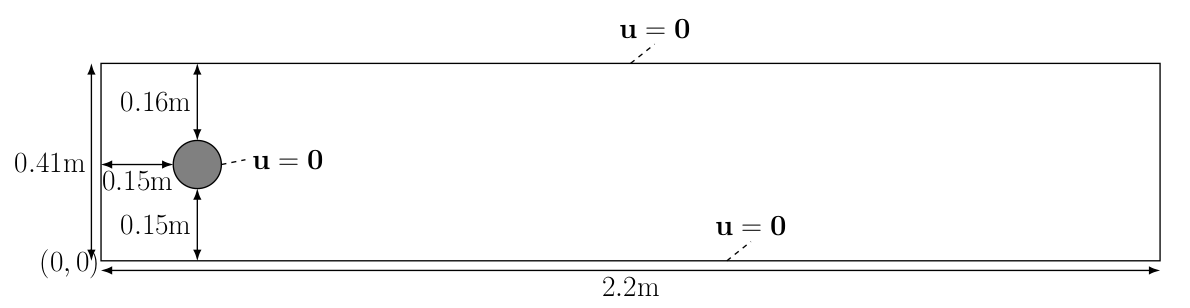

con viscosidad cinematica $\nu = 0.001 = \frac{\mu}{\rho}$ $\mu$ viscosidad dinamica, $\rho$ densidad del fluido

la velocidad de entrada esta dada por:

$u(x,y,t) = \left( \frac{4Uy(0.41-y)}{0.41^2}, 0 \right)$

velocidad característica:

$U=U(t) = 1.5\sin(\pi t/8)$

#### Creación de la malla con GMSH

In [1]:
import gmsh
from mpi4py import MPI
import numpy as np
from dolfinx.io import gmshio

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y = 0.2
r = 0.05
gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

se quita el cilindro a el rectangulo

In [2]:
if mesh_comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

Se le añade un tag al fluido

In [3]:
fluid_marker = 1
if mesh_comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    assert (len(volumes) == 1)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

Se añaden los marcadores 2 a el flujo de entrada, 3 al flujo de salida, 4 a las paredes, 5 al cilindro

In [4]:
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if mesh_comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

Se crea la malla con tamaños variables, más fina alrededor del cilindro

In [5]:
res_min = r / 3
if mesh_comm.rank == model_rank:
    distance_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
    threshold_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold_field, "IField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.25 * H)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", r)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 2 * H)
    min_field = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(min_field, "FieldsList", [threshold_field])
    gmsh.model.mesh.field.setAsBackgroundMesh(min_field)

Se crea la malla usando cuadrilateros de segundo order, como se especifica en el benchmark

In [6]:
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.Algorithm", 8)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.setOrder(2)
    gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00488692s, CPU 0.00448s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.00153278s, CPU 0.001576s): 103 quads, 16 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.82361, min Q = 0.425555
Info    : Simple recombination completed (Wall 0.00223006s, CPU 0.002313s): 460 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.865979, min Q = 0.499255
Info    : Done meshing 2D (Wall 0.00652361s, CPU 0.006752s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 60%] Meshi

Cargar la malla en fenicsx

In [7]:
domain, _, ft = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
ft.name = "Facet markers"

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


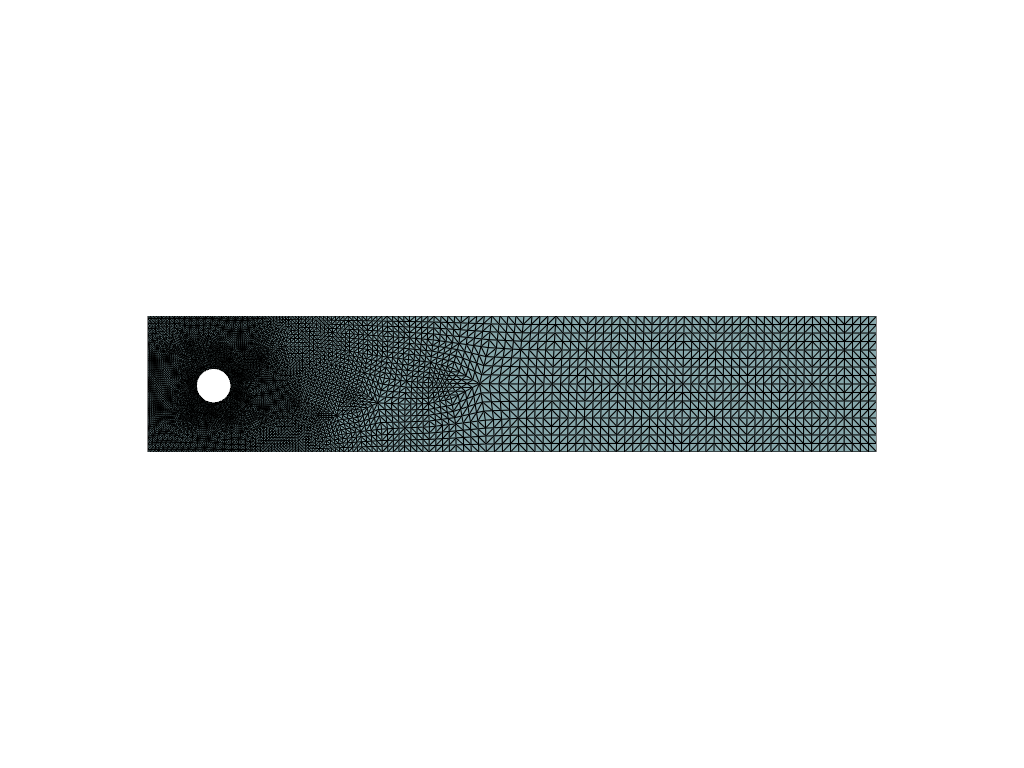

In [8]:
from dolfinx import plot
import pyvista
pyvista.start_xvfb()
domain.topology.create_connectivity(2, 2)
domain.topology.create_connectivity(2, 1)
topology, cell_types, geometry = plot.vtk_mesh(domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

Parámetros del benchmark

In [9]:
from dolfinx.fem import Constant, Function, dirichletbc, locate_dofs_topological, form, functionspace
from dolfinx import io
from basix.ufl import element
from petsc4py import PETSc
import ufl
from ufl import FacetNormal, Measure, inner, as_vector, dx, ds, dot, sym, nabla_grad, Identity, lhs, rhs, div, grad

In [10]:
t = 0
T = 8 # final
dt = 1 / 400                
num_steps = int(T / dt)
k = Constant(domain, PETSc.ScalarType(dt))
mu = Constant(domain, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(domain, PETSc.ScalarType(1))     # Density

Condiciones de frontera

In [11]:
element_velocity = element("Lagrange", domain.topology.cell_name(), 2, shape=(domain.geometry.dim,))
element_pressure = element("Lagrange", domain.topology.cell_name(), 1)
velocity_space = functionspace(domain, element_velocity) 
pressure_space = functionspace(domain, element_pressure)
fdim = domain.geometry.dim - 1

class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41**2)
        return values

# inlet
u_inlet = Function(velocity_space)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(velocity_space, fdim, ft.find(inlet_marker)))
# walls
u_nonslip = np.array((0,) * domain.geometry.dim, dtype=PETSc.ScalarType)
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(velocity_space, fdim, ft.find(wall_marker)), velocity_space)
# obstacle
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(velocity_space, fdim, ft.find(obstacle_marker)), velocity_space)
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]
# outlet
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(pressure_space, fdim, ft.find(outlet_marker)), pressure_space)
bcp = [bcp_outlet]

In [12]:
u = ufl.TrialFunction(velocity_space)
p = ufl.TrialFunction(pressure_space)

v = ufl.TestFunction(velocity_space)
q = ufl.TestFunction(pressure_space)

u_sol = Function(velocity_space) # guarda la solucion del tiempo actual
u_prev = Function(velocity_space) # guarda la solucion del tiempo anterior
p_sol = Function(pressure_space) 
p_prev = Function(pressure_space)

f = Constant(domain, PETSc.ScalarType((0, 0)))

Formas variacionales para computar parámetros físicos que se comparan con los del benchmark
$$
C_{\text{D}}(u,p,t,\partial\Omega_S) = \frac{2}{\rho L U_{mean}^2}\int_{\partial\Omega_S}\rho \nu n \cdot \nabla u_{t_S}(t)n_y -p(t)n_x~\mathrm{d} s,
$$

$$
C_{\text{L}}(u,p,t,\partial\Omega_S) = -\frac{2}{\rho L U_{mean}^2}\int_{\partial\Omega_S}\rho \nu n \cdot \nabla u_{t_S}(t)n_x + p(t)n_y~\mathrm{d} s,
$$

In [13]:
n = -FacetNormal(domain)  # Normal pointing out of cylinder
dObs = Measure("ds", domain=domain, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u_sol)
drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] - p_sol * n[0]) * dObs)
lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] + p_sol * n[1]) * dObs)
if domain.comm.rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)

Para el benchmark, hay que evaluar la presión en dos puntos, entonces hay que buscar las celdas que les corresponden para evaluar.

In [14]:
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells

tree = bb_tree(domain, domain.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(domain, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if domain.comm.rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

Forma variacional IPCS: 
- linealización del termino convectivo usando el paso anterior
- discretización en el tiempo con diferencias finitas hacia atras

In [15]:
u_midpoint = 0.5*(u_prev + u)
n = FacetNormal(domain)

def epsilon(u):
    return sym(nabla_grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# step 1
form1 = rho*dot((u - u_prev) / dt, v)*dx \
      + rho*dot(dot(u_prev, nabla_grad(u_prev)), v)*dx \
      + inner(sigma(u_midpoint, p_prev), epsilon(v))*dx \
      + dot(p_prev*n, v)*ds - dot(mu*nabla_grad(u_midpoint)*n, v)*ds \
      - dot(f, v)*dx
bilinear1 = lhs(form1)
linear1 = rhs(form1)

# step 2
form2 = dot(nabla_grad(p), nabla_grad(q))*dx \
      - dot(nabla_grad(p_prev), nabla_grad(q))*dx \
      + (rho/dt)*div(u_sol)*q*dx
bilinear2 = lhs(form2)
linear2 = rhs(form2)

# step 3
form3 = rho*dot((u - u_sol), v)*dx \
      + dt*dot(nabla_grad(p_sol - p_prev), v)*dx
bilinear3 = lhs(form3)
linear3 = rhs(form3)

In [16]:
t_p

array([0., 0., 0., ..., 0., 0., 0.])

In [17]:
from dolfinx.fem.petsc import LinearProblem
from dolfinx.fem import assemble_scalar
from tqdm.notebook import tqdm
from datetime import date

t = 0
u_file = io.VTXWriter(domain.comm, f"{date.today()}/velocity.bp", u_sol)
p_file = io.VTXWriter(domain.comm, f"{date.today()}/pressure.bp", p_sol)
u_file.write(t)
p_file.write(t)

comm = u_sol.function_space.mesh.comm
progress = tqdm(desc="Resolviendo navier-stokes", total=num_steps)

for i in range(num_steps):
    progress.update()
    t += dt
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)
    
    problem1 = LinearProblem(bilinear1, linear1, bcu, u_sol)
    problem1.solve()

    problem2 = LinearProblem(bilinear2, linear2, bcp, p_sol)
    problem2.solve()

    problem3 = LinearProblem(bilinear3, linear3, bcu, u_sol)
    problem3.solve()

    u_file.write(t)
    p_file.write(t)
    
    u_prev.x.array[:] = u_sol.x.array
    p_prev.x.array[:] = p_sol.x.array

    # calcular cantidades fisicas
    drag_coeff = domain.comm.gather(assemble_scalar(drag), root=0)
    lift_coeff = domain.comm.gather(assemble_scalar(lift), root=0)
    p_front = None
    if len(front_cells) > 0:
        p_front = p_sol.eval(points[0], front_cells[:1])
    p_front = domain.comm.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_sol.eval(points[1], back_cells[:1])
    p_back = domain.comm.gather(p_back, root=0)
    if domain.comm.rank == 0:
        t_u[i] = t
        t_p[i] = t - dt / 2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break

progress.close()
p_file.close()
u_file.close()

Resolviendo navier-stokes:   0%|          | 0/12800 [00:00<?, ?it/s]

### Resultados

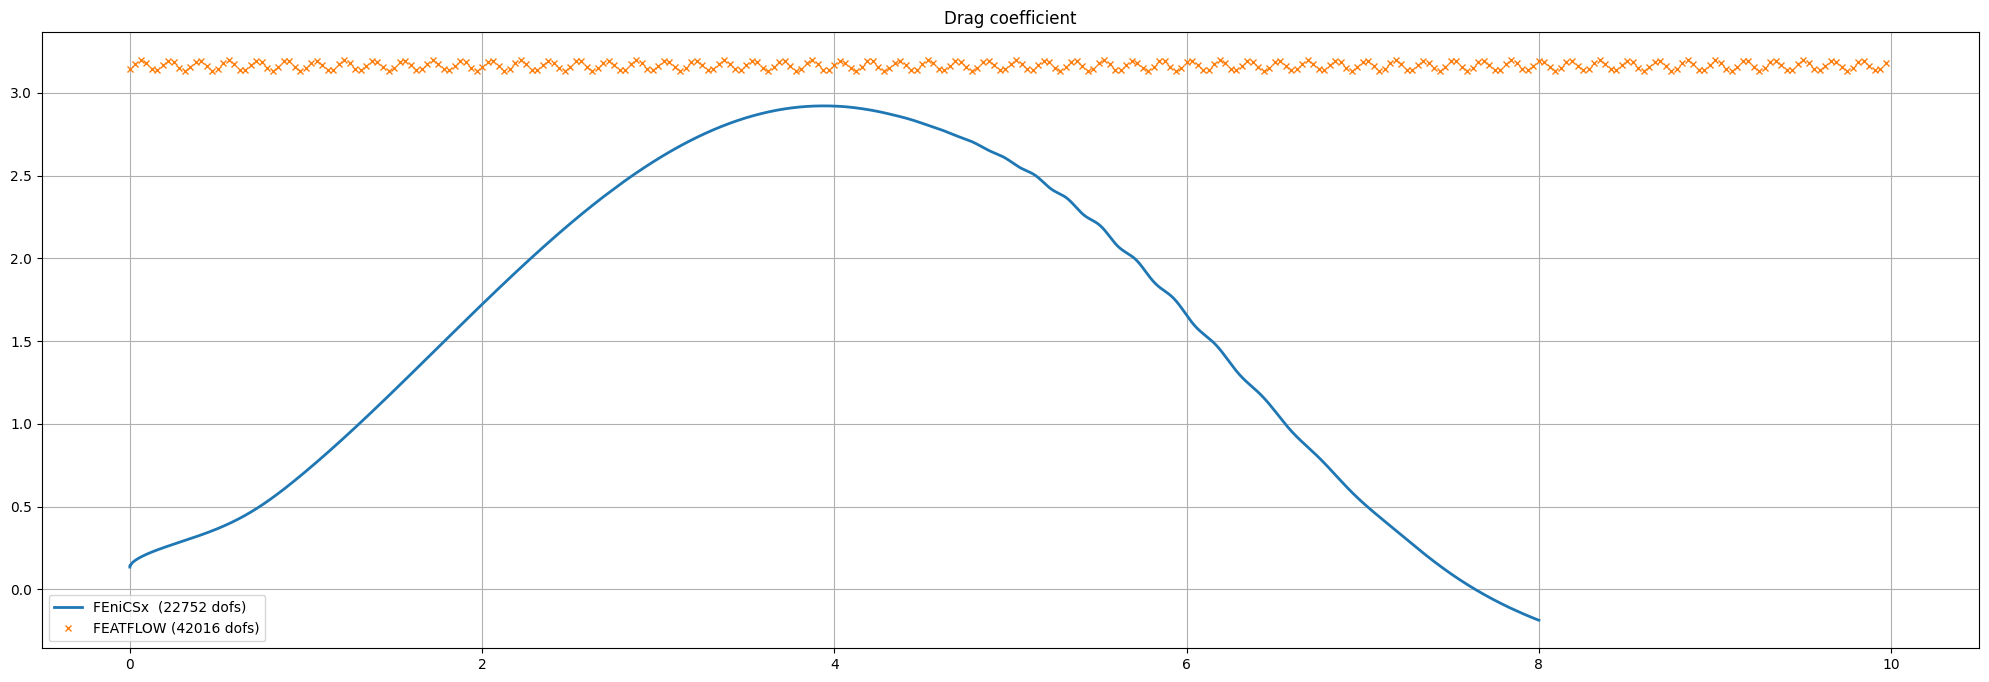

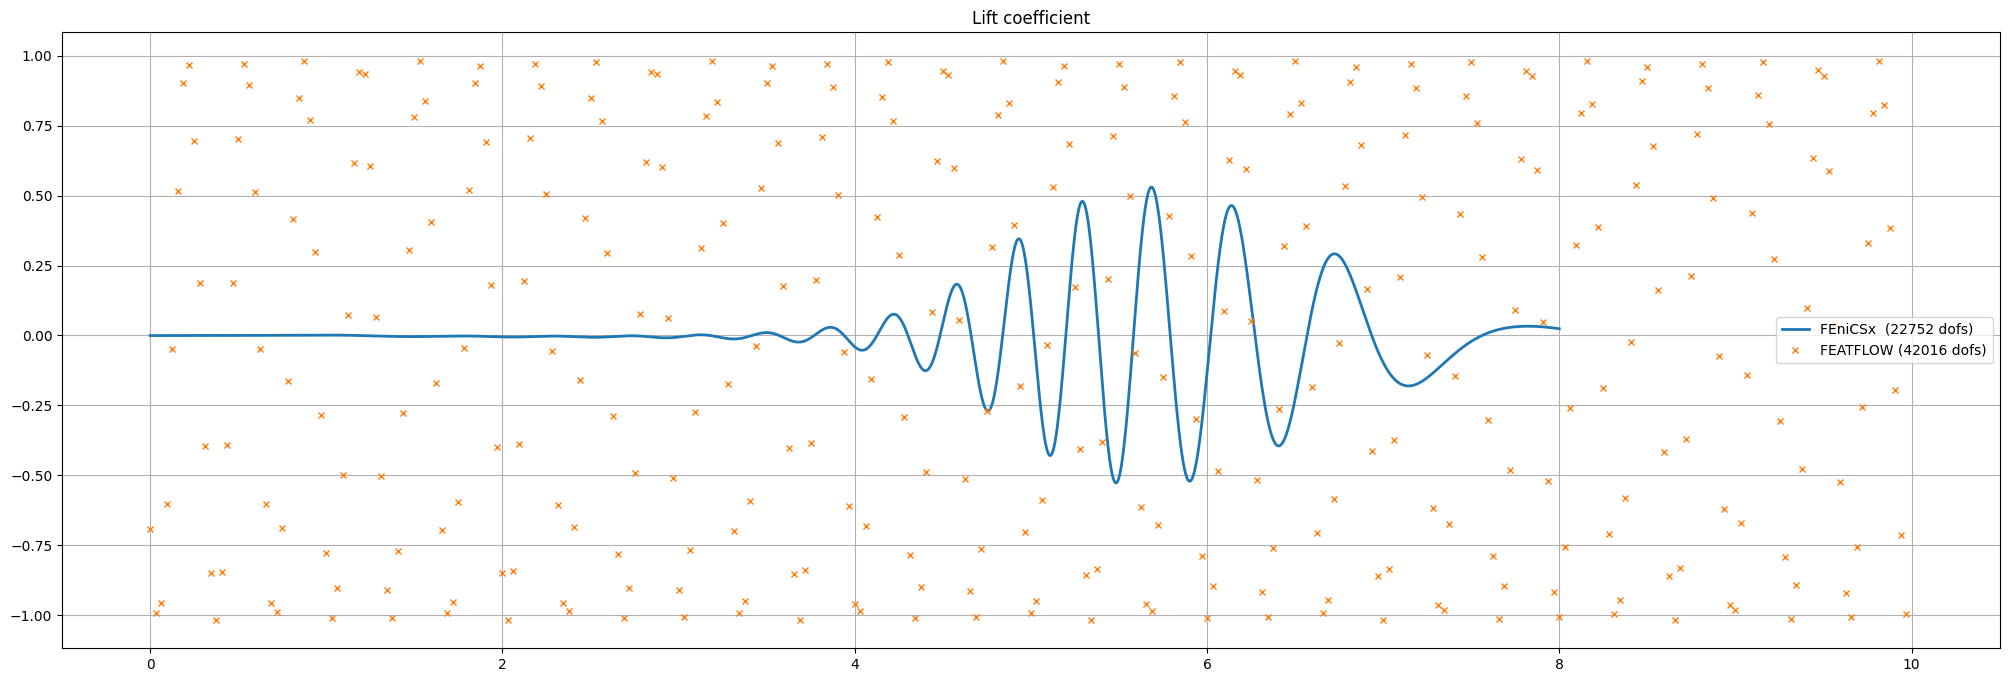

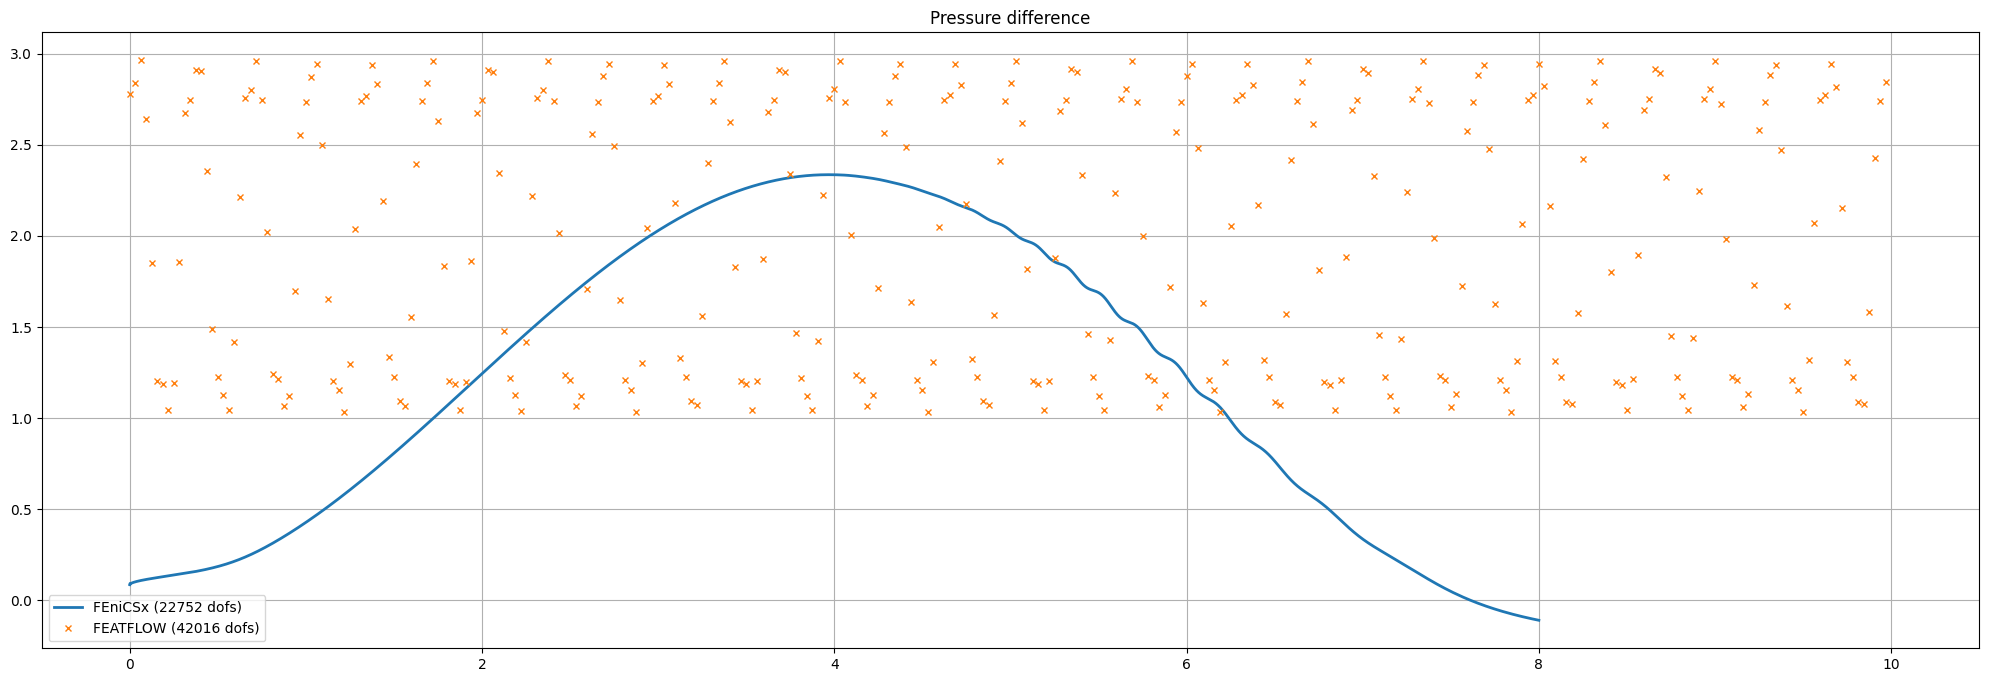

In [19]:
import os
import matplotlib.pyplot as plt

if domain.comm.rank == 0:
    if not os.path.exists("figures"):
        os.mkdir("figures")
    num_velocity_dofs = velocity_space.dofmap.index_map_bs * velocity_space.dofmap.index_map.size_global
    num_pressure_dofs = pressure_space.dofmap.index_map_bs * velocity_space.dofmap.index_map.size_global

    turek = np.loadtxt("benchmark_data/bdforces_q2_lv4_dt4")
    turek_p = np.loadtxt("benchmark_data/pointvalues_q2_lv4_dt4")
    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek[1:, 3], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/drag_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_L, label=r"FEniCSx  ({0:d} dofs)".format(
        num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek[1:, 4], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/lift_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_p, p_diff, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek_p[1:, 6] - turek_p[1:, -1], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Pressure difference")
    plt.grid()
    plt.legend()
    plt.savefig("figures/pressure_comparison.png")